# EDA

##### Seperating the Data

In [7]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [8]:
df = pd.read_csv('raw_data.csv')

In [9]:
df['product02'].value_counts()

product02
Nee    5618
Ja     3906
Name: count, dtype: int64

In [10]:
ja_sample = df[df.product02 =='Ja'].sample(100)
na_sample = df[df.product02 =='Nee'].sample(100)

test_sample = pd.concat([ja_sample,na_sample])
test_sample.to_csv('./data/input/test_data.csv')

In [11]:
train_data = df[~df.subscriber.isin(test_sample['subscriber'].values)]
train_data.to_csv('./data/input/train_data.csv')

### Analysing

In [15]:
# Extract dates info
train_data["lastVisit"] = pd.to_datetime(train_data["lastVisit"], errors="coerce")
train_data.loc[:,"visit_Year"] = train_data["lastVisit"].dt.year
train_data.loc[:,"visit_Month"] = train_data["lastVisit"].dt.month
train_data.loc[:,"visit_Day"] = train_data["lastVisit"].dt.day
train_data.loc[:,"visit_Dayofweek"] = train_data["lastVisit"].dt.dayofweek
train_data.loc[:,"visit_Quarter"] = train_data["lastVisit"].dt.quarter

C:\Users\Gemy\AppData\Local\Temp\ipykernel_3840\2099485584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["lastVisit"] = pd.to_datetime(train_data["lastVisit"], errors="coerce")


In [23]:
# Get count of missing values in the dataset
train_data.isnull().sum()

subscriber           0
income             548
age                535
var1               558
gender             540
house_type         532
lastVisit            0
product02            0
visit_Year           0
visit_Month          0
visit_Day            0
visit_Dayofweek      0
visit_Quarter        0
dtype: int64

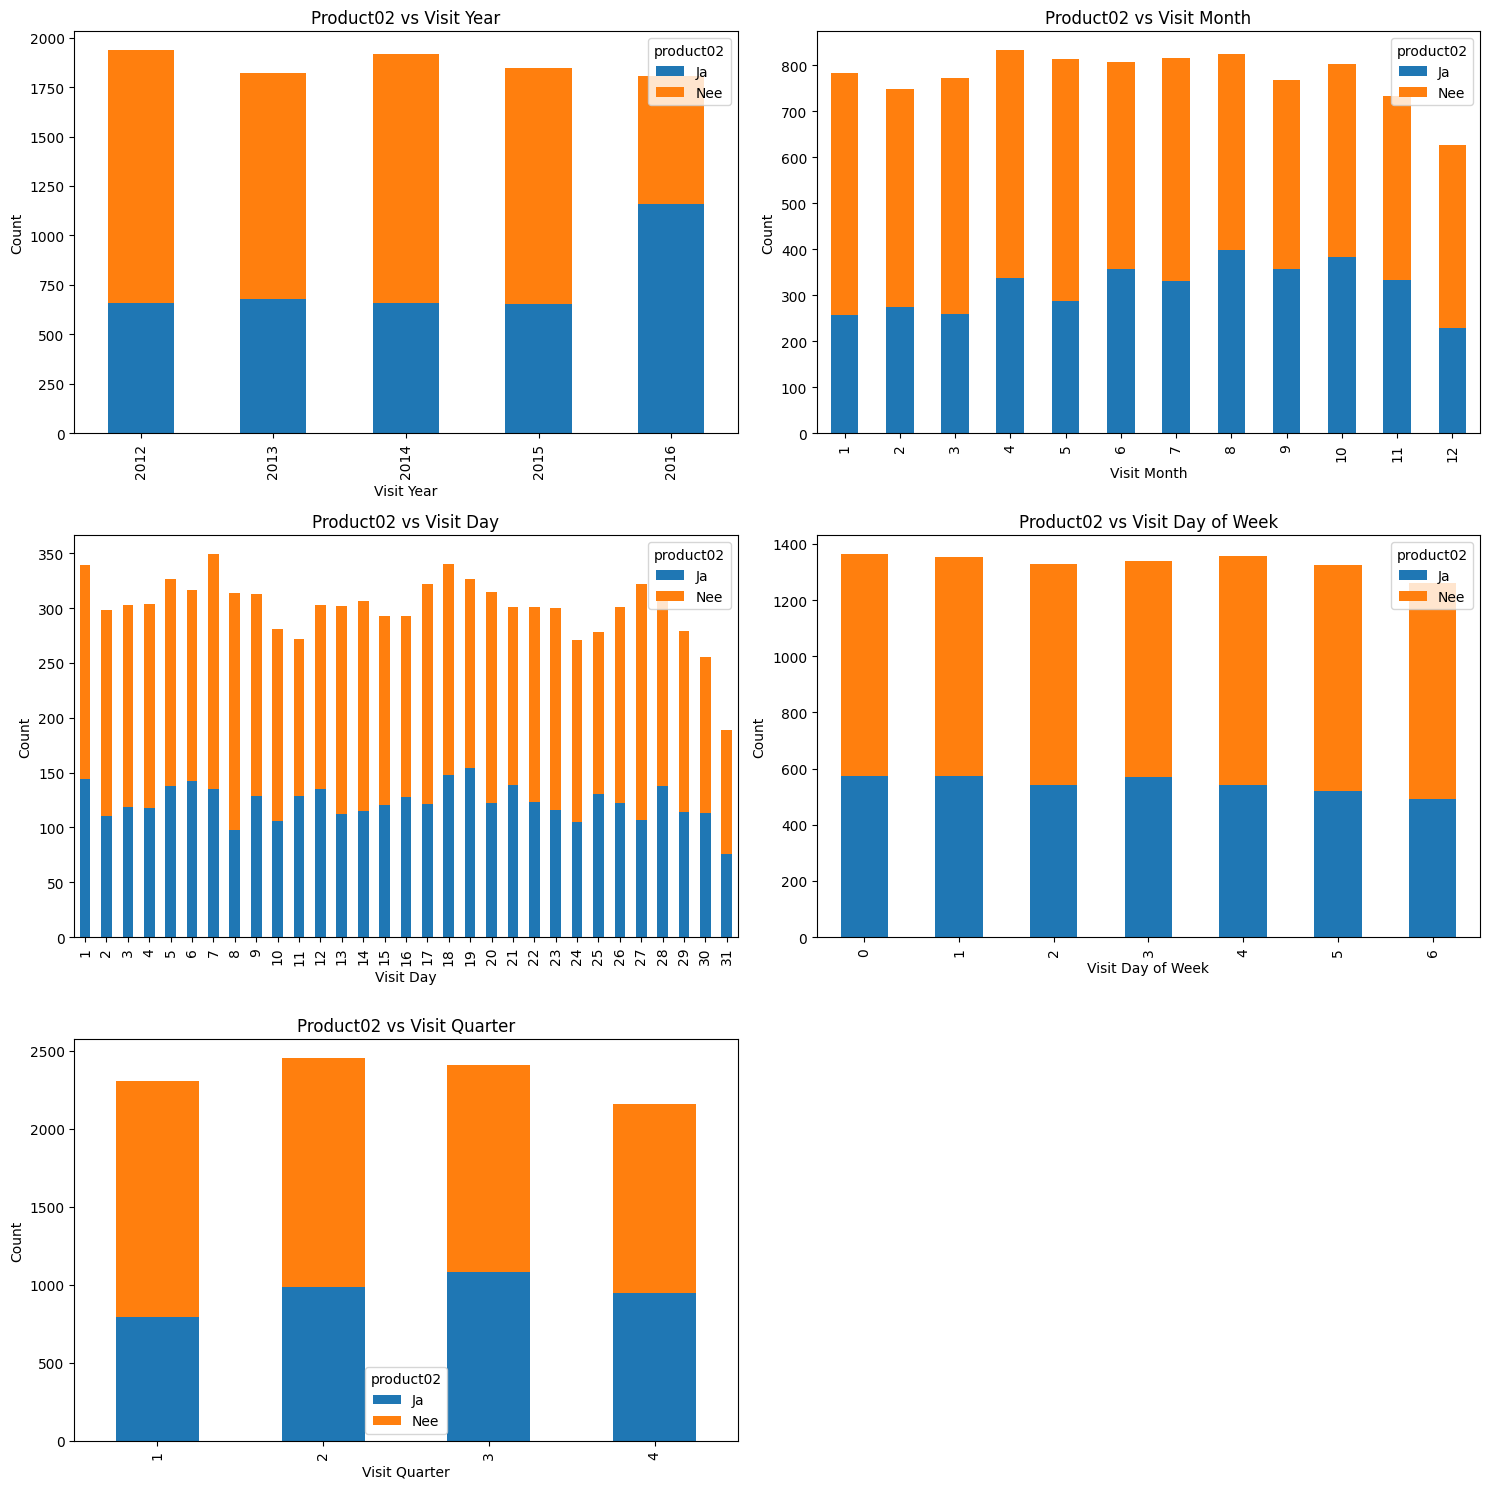

In [27]:

# Create a figure and axes for the subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot for 'visit_Year' vs 'product02'
train_data.groupby(['visit_Year', 'product02']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Product02 vs Visit Year')
axes[0, 0].set_xlabel('Visit Year')
axes[0, 0].set_ylabel('Count')

# Plot for 'visit_Month' vs 'product02'
train_data.groupby(['visit_Month', 'product02']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Product02 vs Visit Month')
axes[0, 1].set_xlabel('Visit Month')
axes[0, 1].set_ylabel('Count')

# Plot for 'visit_Day' vs 'product02'
train_data.groupby(['visit_Day', 'product02']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Product02 vs Visit Day')
axes[1, 0].set_xlabel('Visit Day')
axes[1, 0].set_ylabel('Count')

# Plot for 'visit_Dayofweek' vs 'product02'
train_data.groupby(['visit_Dayofweek', 'product02']).size().unstack().plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Product02 vs Visit Day of Week')
axes[1, 1].set_xlabel('Visit Day of Week')
axes[1, 1].set_ylabel('Count')

# Plot for 'visit_Quarter' vs 'product02'
train_data.groupby(['visit_Quarter', 'product02']).size().unstack().plot(kind='bar', stacked=True, ax=axes[2, 0])
axes[2, 0].set_title('Product02 vs Visit Quarter')
axes[2, 0].set_xlabel('Visit Quarter')
axes[2, 0].set_ylabel('Count')

# Hide the empty subplot
axes[2, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
# Checking the distribution of the null values across rows 
train_data.isnull().sum(axis=1).value_counts()

0    8118
2     419
3     334
1     318
4     120
5      15
Name: count, dtype: int64

In [25]:
# Drop rows that have more than 2 missing values.
train_data[train_data.isnull().sum(axis=1) <= 2].isnull().sum()

subscriber           0
income             221
age                235
var1               237
gender             237
house_type         226
lastVisit            0
product02            0
visit_Year           0
visit_Month          0
visit_Day            0
visit_Dayofweek      0
visit_Quarter        0
dtype: int64

In [45]:
data_cleaned = train_data.dropna(subset=['age', 'income', 'gender', 'house_type', 'product02', 'lastVisit'])

# Income vs Age by Gender
fig_income_age_gender = px.scatter(data_cleaned, x='age', y='income', color='gender', title='Income vs Age by Gender',
                                   labels={'age': 'Age', 'income': 'Income'}, hover_data=['house_type'])
fig_income_age_gender.show()

# Income Distribution by House Type
fig_income_house = px.box(data_cleaned, x='house_type', y='income', title='Income Distribution by House Type', 
                          labels={'house_type': 'House Type', 'income': 'Income'})
fig_income_house.show()

# Product02 vs Income
fig_product_income = px.violin(data_cleaned, x='product02', y='income', title='Income Distribution for Product02 (Ja vs Nee)', 
                               box=True, points="all", labels={'product02': 'Product02', 'income': 'Income'})
fig_product_income.show()

# Time Series Analysis: Number of visits per month
# Extract year and month from lastVisit
data_cleaned["lastVisit"] = pd.to_datetime(data_cleaned["lastVisit"], errors="coerce")
data_cleaned['visit_year_month'] = data_cleaned['lastVisit'].dt.to_period('M')

# Count the number of visits per month
visits_per_month_cleaned = data_cleaned['visit_year_month'].value_counts().sort_index()

# Reset index for plotting
visits_per_month_df = visits_per_month_cleaned.reset_index()
visits_per_month_df.columns = ['Year-Month', 'Number of Visits']

# Convert 'Year-Month' to string for Plotly compatibility
visits_per_month_df['Year-Month'] = visits_per_month_df['Year-Month'].astype(str)

# Create the time series line chart
fig_visits_time_series = px.line(visits_per_month_df, x='Year-Month', y='Number of Visits',
                                 title='Number of Visits per Month',
                                 labels={'Year-Month': 'Year-Month', 'Number of Visits': 'Number of Visits'})

# Display the plot
fig_visits_time_series.show()


C:\Users\Gemy\AppData\Local\Temp\ipykernel_14032\1994899094.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Gemy\AppData\Local\Temp\ipykernel_14032\1994899094.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
# Age Distribution vs Product02
fig_age_product02 = px.violin(data_cleaned, x='product02', y='age', 
                              title='Age Distribution for Product02 (Ja vs Nee)', 
                              box=True, points='all', labels={'product02': 'Product02', 'age': 'Age'})
fig_age_product02.show()

# 5. Income vs Age, color-coded by Product02
fig_income_age_product02 = px.scatter(data_cleaned, x='age', y='income', color='product02', 
                                      title='Income vs Age by Product02',
                                      labels={'age': 'Age', 'income': 'Income'})
fig_income_age_product02.show()

In [27]:
profile = ProfileReport(train_data, title="Profiling Report")
profile.to_file("dataReport.html")

C:\Users\Gemy\AppData\Local\Temp\ipykernel_20612\4281834603.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['product02'] = train_data['product02'].replace({"Ja":1,"Nee":0})
C:\Users\Gemy\AppData\Local\Temp\ipykernel_20612\4281834603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['product02'] = train_data['product02'].replace({"Ja":1,"Nee":0})
e:\Use Cases\tmobile-nl-main\.venv\lib\site-packages\ydata_profiling\utils\dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

e:\Use Cases\tmobile-nl-main\.venv\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
e:\Use Cases\tmobile-nl-main\.venv\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 9 9]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
e:\Use Cases\tmobile-nl-main\.venv\lib\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Va

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## EDA Results
1 - Income,as expected, is skewed. We need log scaling and rounding for this if we are going to use a parametric model. Also Income seems to be a good predictor since low income customers are more associated with "NEE".

2 - Age is also log normal.

3 - The Date info seems to be promising. The "Year" part seems to have a good impact on the acceptance and the year 2016 stands out as a year of good performance for the product. Advice should be given to business to follow through on their stratgies with regards to this year. Also, the "Month" part could prove to be useful.

4 - There's Missing data in different columns.

5 - Medium +ve corr between Var1 and house_type. Medium -ve corr between Var1 and age. 

6 - Medium +ve corr between age, income and gender.

7 - The Target variable is imbalanaced. We need to address this. (Usin class weight + weighted scoring Now, tried SMOTE but no lift) 

8 - it seems that our customers among 60+ population are mainly focused towards women.

9 - Our customer base seems to be mostly made of Young and middle aged customers.

## Future Improvments Ideas:

1 - Try Filling out missing values using smart imputation (KNN or Prediction)

2 - Try different ways for handling imbalance in the Data instead of class weight.

2 - Try out different models with extra feature engineering (transformations)

3 - Use logging instead of print statments.

4 - Use interaction variables.

## Final Notes:

Optimizing for Precision vs Recall in model training would depend on business context. For example, if you are using the model to send marketing offers and you want to optimize for not sending too many offers (for cost or convenience reasons), you will try to optimize for Precision. On the other hand, if the goal is to maximize revenue and don't want to lose out on potential sales, optimize for Recall.

In [28]:
import joblib

pipeline = joblib.load("models/train_pipeline.pkl")
pipeline

Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['income', 'age', 'var1']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'house_type',
                                                   'income_bucket',
                                                   'age_bucket'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_split=5,
                                        random_state=60))])

In [35]:
feature_names =['num__income','num__age' 'num__var1','num__visitTime_Year','num__visitTime_Month',
 'cat__gender_f','cat__gender_m','cat__house_type_OWNER',
 'cat__house_type_RENTAL','cat__income_bucket_High',
 'cat__income_bucket_Low','cat__income_bucket_Medium',
 'cat__income_bucket_Very High','cat__age_bucket_Middle-aged',
 'cat__age_bucket_Senior','cat__age_bucket_Youth']

clean_feature_names = [name.split("__")[-1] for name in feature_names]
[x.split("_")[0] for x in clean_feature_names]

['income',
 'var1',
 'visitTime',
 'visitTime',
 'gender',
 'gender',
 'house',
 'house',
 'income',
 'income',
 'income',
 'income',
 'age',
 'age',
 'age']

In [33]:
train_data.groupby('visit_Year')['product02'].sum()

visit_Year
2012     660
2013     675
2014     660
2015     653
2016    1158
Name: product02, dtype: int64